In [0]:
from google.colab import drive

drive.mount('/content/drive')

import os 

os.chdir("/content/drive/My Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import pandas as pd

files = sorted(glob.glob('./pose_output/*'))

In [0]:
coding = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "MidHip", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "LBigToe", "LSmallToe", "LHeel", "RBigToe", "RSmallToe", "RHeel"]

col_name = ["frame", "person"]
for code in coding:
    col_name.append(code+'_x')
    col_name.append(code+'_y')
    col_name.append(code+'_c')

pose_data = pd.DataFrame(columns=col_name)
pose_data.shape

(0, 77)

In [0]:
f = 0

for file in files:
    data = pd.read_json(file)
    if data.shape[0] > 0: 
        for i in range(data.shape[0]):
            row = [f, i]
            row = row + data['people'].iloc[i]['pose_keypoints_2d']
            pose_data = pose_data.append(pd.Series(row, col_name), ignore_index=True)
    f += 1

In [0]:
pose_data.to_csv('./pose_data.csv')

In [0]:
import matplotlib.pyplot as plt
def plot_pose(data):
    kps = list(data.iloc[2:])
    xs = kps[::3]
    ys = kps[1::3]
    plt.scatter(xs, ys)
    plt.xlim(0, 1280)
    plt.ylim(0, 920)
    plt.show()
    

In [0]:


pose_data = pd.read_csv('./pose_data.csv')

In [0]:
test = pose_data.iloc[470:980]

In [0]:
!pip3 install filterpy

import pandas as pd
import numpy as np
from numpy.linalg import inv
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt


'''
2D Kalman Filter, Tracking Position, Velocity, Acceleration & Jitter
'''

def tracker_4dof(noise=0.02, time=1.0):
    q = noise
    dt = time
    tracker = KalmanFilter(dim_x=8, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3), 0],
                          [0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0., 1 / 6 * (dt ** 3)],
                          [0., 0., 1., 0., dt, 0., 1 / 2 * (dt ** 2), 0],
                          [0., 0., 0., 1., 0, dt, 0., 1 / 2 * (dt ** 2)],
                          [0., 0., 0., 0., 1., 0., dt, 0.],
                          [0., 0., 0., 0., 0, 1., 0., dt],
                          [0., 0., 0., 0., 0, 0., 1., 0.],
                          [0., 0., 0., 0., 0, 0., 0., 1.]])
    tracker.H = np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                          [0., 1., 0., 0., 0., 0., 0., 0.],])
    tracker.R = np.array([[1.0, 0],
                          [0, 1.0]])
    tracker.P = np.eye(8) * 1000.
    tracker.Q = np.array([[0., 0., q, 0., q, 0., q, 0.],
                          [0., 0., 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q, 0., q]])
    return tracker


def tracker_3dof(noise=0.02, time=1.0):
    q = noise
    dt = time
    tracker = KalmanFilter(dim_x=6, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0., 1 / 2 * (dt ** 2), 0.],
                          [0., 1., 0., dt, 0., 1 / 2 * (dt ** 2)],
                          [0., 0., 1., 0., dt, 0.],
                          [0., 0., 0., 1., 0, dt],
                          [0., 0., 0., 0., 1., 0.],
                          [0., 0., 0., 0., 0, 1.]])
    tracker.H = np.array([[1., 0., 0., 0., 0., 0.],
                          [0., 1., 0., 0., 0., 0.],])
    tracker.R = np.array([[1., 0],
                          [0, 1.]])
    tracker.P = np.eye(6) * 1000.
    tracker.Q = np.array([[0., 0., q, 0., q, 0.],
                          [0., 0., 0., q, 0., q],
                          [q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q],
                          [q, 0., q, 0., q, 0.],
                          [0., q, 0., q, 0., q]])
    return tracker

def tracker_2dof(noise=0.01, time=1.0):
    q = noise
    dt = time
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    tracker.x = np.array([0.0, 0.0, 0.0, 0.0])
    tracker.F = np.array([[1., 0., dt, 0.],
                          [0.,1., 0., dt],
                          [0., 0., 1., 0.],
                          [0., 0., 0., 1.]])
    tracker.H = np.array([[1., 0., 0., 0.],
                          [0., 1., 0., 0.]])
    tracker.R = np.array([[1., 0],
                          [0, 1.]])
    tracker.P = np.eye(4) * 1000.
    tracker.Q = np.array([[0, 0., q, 0.],
                          [q, 0., q, 0.],
                          [0., 0., 0., q],
                          [0., q, 0., q]])
    return tracker


     |████████████████████████████████| 184kB 4.9MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110453 sha256=3213036c67772348f9f3532577c2849708f1a12385b562998bb15d37ad57a188
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


Loss w/ Filter: 34.964003289904035
Loss wt/ Filter: 0.20441565271769188


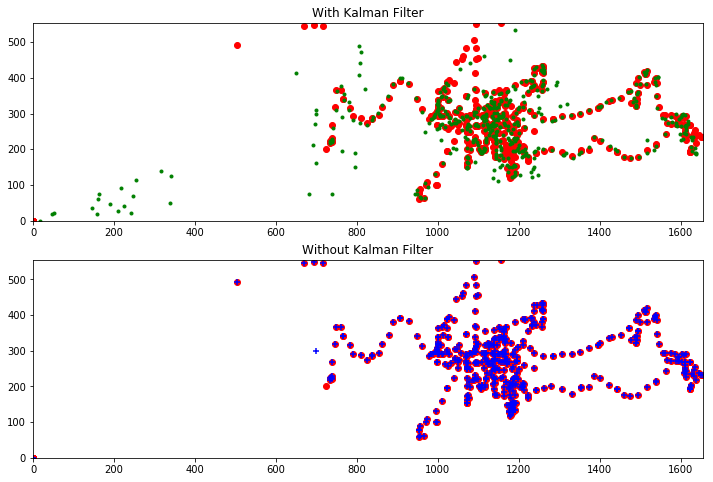

In [0]:
step = 500
c = test

KF_2D = tracker_4dof()
preds = []
truths = []
measure = []
res_x = []
res_y = []
count = [_ for _ in range(step)]
z = np.array([700, 300])

for _ in range(step):
    KF_2D.predict()
    KF_2D.update(z)
    preds.append([KF_2D.x[0], KF_2D.x[1]])
    truths.append([c['Neck_x'].iloc[_], c['Neck_y'].iloc[_]])
    measure.append([z[0], z[1]])
    z = np.array([c['Neck_x'].iloc[_+1], c['Neck_y'].iloc[_+1]])
    res_x.append(KF_2D.y[0])
    res_y.append(KF_2D.y[1])
    
def loss(predict, target):
    import math
    assert len(predict) == len(target)
    losses = 0
    for _ in range(len(predict)):
        losses = losses + math.hypot(float(predict[_][0])-float(target[_][0]), float(predict[_][1])-float(target[_][1]))
    return losses

print('Loss w/ Filter:', loss(truths, preds)/step)
print('Loss wt/ Filter:', loss(truths, measure)/step)

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.xlim(c['Neck_x'].min(), c['Neck_x'].max())
plt.ylim(c['Neck_y'].min(), c['Neck_y'].max())
plt.title('With Kalman Filter')
plt.scatter([truths[_][0] for _ in range(len(preds))], [truths[_][1] for _ in range(len(preds))], color='red')
plt.scatter([preds[_][0] for _ in range(len(preds))], [preds[_][1] for _ in range(len(preds))], color='green', marker='.')

plt.subplot(2,1,2)
plt.xlim(c['Neck_x'].min(), c['Neck_x'].max())
plt.ylim(c['Neck_y'].min(), c['Neck_y'].max())
plt.title('Without Kalman Filter')
plt.scatter([truths[_][0] for _ in range(len(preds))], [truths[_][1] for _ in range(len(preds))], color='red')
plt.scatter([measure[_][0] for _ in range(len(preds))], [measure[_][1] for _ in range(len(preds))], color='blue', marker='+')

plt.show()

In [0]:
t = np.array(truths)
t.T.shape

(2, 500)

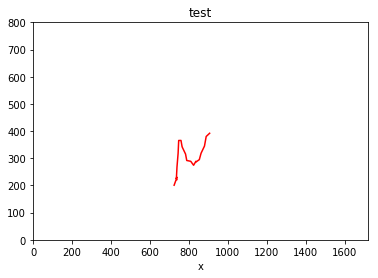

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,
  
fig1 = plt.figure()

# Fixing random state for reproducibility
np.random.seed(19680801)

data = t.T
l, = plt.plot([], [], 'r-')
plt.xlim(0, 1720)
plt.ylim(0, 800)
plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)

line_ani.save('./lines.mp4')

In [0]:
data.shape

(2, 500)